#  Generate kmz file for AOI using asf-search

In [63]:
import numpy as np
import asf_search as asf
import pandas as pd
import geopandas as gpd
import fiona

from pathlib import Path
from shapely.geometry import Polygon
from rasterio.crs import CRS
from dateutil.parser import parse as parse_date

In [20]:
#Select the working directory and name the project

output_name = 'OPERA'
work_dir = Path('/Users/govorcin/Projects/PROJECTS/ACCESS/') 
print(work_dir)

/Users/govorcin/Projects/PROJECTS/ACCESS


In [118]:
#AOI

# EDIT MANUALLY 
## Use ASF vertex to select aoi and copy WKT geometry

# North America by OPERA
#wkt = 'POLYGON((-140.2088 69.4264,-156.0291 70.9738,-164.6424 68.544,-162.8846 66.178,-168.5096 65.7484,-164.6424 63.0944,-163.5877 58.745,-168.8611 53.7742,-150.5799 58.9269,-140.2088 59.198,-125.9705 50.0919,-123.5096 39.6728,-112.2596 25.0451,-88.8807 10.5303,-79.3885 6.3582,-79.3885 9.8382,-87.1229 19.6833,-96.7908 20.0139,-95.2088 27.8773,-83.6072 27.566,-81.3221 24.4064,-79.9158 27.4101,-78.158 33.614,-66.7322 45.1195,-64.0955 46.8296,-67.7869 49.296,-78.158 47.0696,-92.0447 51.0961,-121.0486 51.5356,-133.1776 56.4863,-135.4627 58.5621,-136.1658 68.6723,-140.2088 69.4264))'

# CA
wkt = 'POLYGON((-142.0686 28.2992,-102.6532 28.2992,-102.6532 55.8676,-142.0686 55.8676,-142.0686 28.2992))'

# LOAD SHAPEFILE
#read shapefile
shapefile_filename = '/Users/govorcin/Projects/VLM/VLM/CA/ca-state-boundary/CA_State_TIGER2016.shp'
aoi_shapefile = gpd.GeoDataFrame.from_file(shapefile_filename)

#Get it in WGS84
aoi_shapefile = aoi_shapefile.to_crs(4326)

#get wkt
wkt = aoi_shapefile.geometry[0].wkt

<AxesSubplot: >

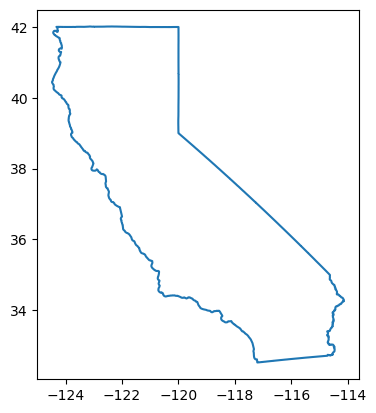

In [132]:
#Plot aoi

aoi_shapefile.boundary.plot()

In [120]:
# Use None to download all tracks and both flight directions
path_number = None
direction_options = ['DESCENDING', 'ASCENDING', None]

track_direction_ix = 0

#Use asf search to get frames covering aoi
#Change below start and end date for specific dates
search_results = asf.geo_search(
    platform=asf.SENTINEL1,
    intersectsWith=wkt,
    start='2013-05-18',
    end='2023-05-12',
    processingLevel=asf.SLC,
    beamMode=asf.IW,
    relativeOrbit=path_number,
    flightDirection=direction_options[track_direction_ix],
)
print(f'Downloaded {len(search_results)} SLCs')

/Users/govorcin/insar/miniconda3/envs/hyp3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Downloaded 7858 SLCs


In [121]:
#Create stack dataframe
columns = list(search_results[0].properties.keys()) + ['geometry']
data = [list(scene.properties.values()) + [scene.geometry] for scene in search_results]

stack = pd.DataFrame(data, columns=columns)
stack['startTime'] = stack.startTime.apply(parse_date)

<AxesSubplot: >

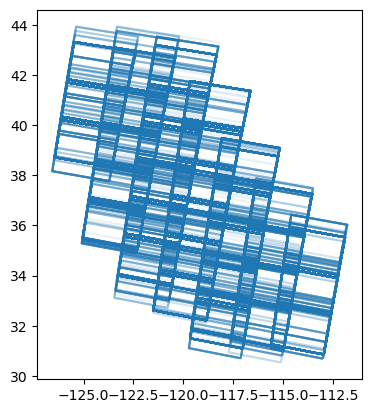

In [131]:
#Get SLCs
SLCs_frame = [Polygon(frame['coordinates'][0]) for frame in stack.geometry]

# Create geo dataframe
geo_stack = gpd.GeoDataFrame(stack, 
                             geometry=SLCs_frame, 
                             crs = CRS.from_epsg(4326))

geo_stack.boundary.plot(alpha=0.1)

In [ ]:
if path_number == None:
    path_number = 'all'
output = str(work_dir) + f'/{output_name}_{direction_options[track_direction_ix][0]}_T{path_number}.kmz'
print(output)

In [ ]:
#SAVE AS KML
fiona.supported_drivers['KML'] = 'rw'
geo_stack.to_file(output, driver='KML', NameField='pathNumber')

## NOTE
add funtion to load kml and organize frame to folders by pathNumber